In [2]:
import matplotlib.pyplot as plt
import cv2
!pip install opencv-python

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/fruits-360_100x100.zip"
extract_dir = "/content/extracted_folder"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


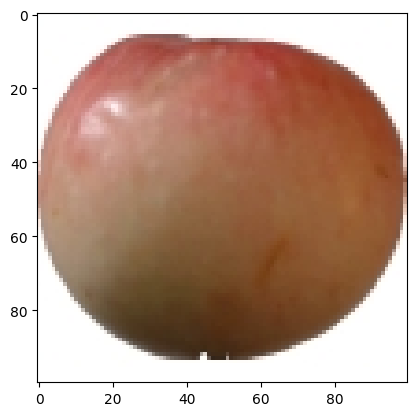

In [4]:
apple=cv2.imread("/content/extracted_folder/fruits-360/Test/Apple 10/r0_103_100.jpg")
apple= cv2.cvtColor(apple,cv2.COLOR_BGR2RGB)
plt.imshow(apple)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
apple.shape

(100, 100, 3)

In [7]:
IMG_SIZE = (224,224,3)

In [8]:
image_shape=(224,224,3)

In [9]:
BATCH_SIZE = 128

In [10]:
image_gen= ImageDataGenerator(rescale=1/255,
                             rotation_range=30,
                             width_shift_range=0.1,
                             shear_range=0.9,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             height_shift_range=0.1,
                             validation_split=0.2) # Set validation split

# Load training data from directory with subset='training'
train_gen = image_gen.flow_from_directory('/content/extracted_folder/fruits-360/Training',
                                        target_size=image_shape[:2],
                                        batch_size=128,
                                        class_mode='categorical',
                                        subset='training') # Specify training subset

# Load validation data from directory with subset='validation'
validation_generator = image_gen.flow_from_directory('/content/extracted_folder/fruits-360/Training',
                                            target_size=image_shape[:2],
                                            batch_size=128,
                                            class_mode='categorical',
                                            subset='validation') # Specify validation subset

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/extracted_folder/fruits-360/Test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 82296 images belonging to 201 classes.
Found 20494 images belonging to 201 classes.
Found 34314 images belonging to 201 classes.


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Example setup
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 10
NUM_CLASSES = 10  # Replace with actual number of fruit classes


In [12]:
train_dir="/content/extracted_folder/fruits-360/Training"
test_dir="/content/extracted_folder/fruits-360/Test"

In [13]:
img_width, img_height = 224,224
batch_size = 128

In [14]:
# Create data generators for train and test data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')


Found 102790 images belonging to 201 classes.
Found 34314 images belonging to 201 classes.


In [15]:
def build_model(base_model):
    base_model.trainable = False  # Freeze base model
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


In [16]:
pretrained_models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3)),
}


In [ ]:


# Training Loop
histories = {}

NUM_CLASSES = train_generator.num_classes
for name, base_model in pretrained_models.items():
    print(f"\nTraining {name}...")
    model = build_model(base_model)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
history = model.fit(train_generator, # Use train_generator instead of train_image_gen
                              epochs=5,
                              steps_per_epoch=157,
                              validation_data=test_generator, # Use test_generator instead of test_image_gen
                             validation_steps=55)

    # Evaluate on test set after trainin
print(f"\nEvaluating {name} on test set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"{name} Test Accuracy: {test_acc:.4f}")

histories[name] = history


Training ResNet50...

Training VGG16...

Training EfficientNetB0...
Epoch 1/5
 26/157 ━━━━━━━━━━━━━━━━━━━━ 28:35 13s/step - accuracy: 0.0064 - loss: 5.3145

In [ ]:
 model.save(model_filename)
    print(f"Saved {name} model to {model_filename}")

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Load Your Saved Models (replace with your actual paths)
from tensorflow.keras.models import load_model

model_eff = load_model('efficientnetb0_model.h5')
model_resnet = load_model('resnet50_model.h5')
model_vgg = load_model('vgg16_model.h5')

# Step 2: Prepare the test generator (make sure it is the same one used for testing)
# Already created earlier:
# test_generator = ...

# Step 3: Predict on test data
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

y_pred_eff = np.argmax(model_eff.predict(test_generator), axis=1)
y_pred_resnet = np.argmax(model_resnet.predict(test_generator), axis=1)
y_pred_vgg = np.argmax(model_vgg.predict(test_generator), axis=1)

# Step 4: Define training times (already known)
training_times = {
    'EfficientNetB0': 41.56,
    'ResNet50': 58.32,
    'VGG16': 72.44
}

# Step 5: Evaluation function
def evaluate_model(y_true, y_pred, name, train_time):
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    acc = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4),
        'Training Time (s)': train_time
    }

# Step 6: Evaluate all models
results = [
    evaluate_model(y_true, y_pred_eff, 'EfficientNetB0', training_times['EfficientNetB0']),
    evaluate_model(y_true, y_pred_resnet, 'ResNet50', training_times['ResNet50']),
    evaluate_model(y_true, y_pred_vgg, 'VGG16', training_times['VGG16']),
]

# Step 7: Show final comparison table
df_results = pd.DataFrame(results)
df_results.sort_values(by='Accuracy', ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
print(df_results.to_markdown(index=False))


In [ ]:
# %%
!pip install ultralytics

In [ ]:


yolo_dataset_path = "/content/extracted_folder/fruits-360/"



In [ ]:
# %%
from ultralytics import YOLO


model = YOLO('yolov8n-cls.pt')

print(f"Starting YOLOv8 training on data in {yolo_dataset_path} for 20 epochs...")
results = model.train(data=yolo_dataset_path, epochs=20, imgsz=100) # Using imgsz=100
print("YOLOv8 training finished.")

In [ ]:

print("Evaluating YOLOv8 model on the test set...")
metrics = model.val()
print("YOLOv8 evaluation finished.")

yolo_accuracy = metrics.top1

print(f"\nYOLOv8 Classification Accuracy on Test Set: {yolo_accuracy:.4f}")



# **Report: Comparison of Deep Learning Models for Fruit Classification**


**1. Introduction**
Briefly state the problem you are addressing (image classification of fruits) and the goal of this report (to compare the performance of several deep learning models and select the most suitable one). Mention the dataset used (Fruits-360).

**2. Models Evaluated**
List the different deep learning models you evaluated using transfer learning. Briefly describe each one (e.g., "VGG16: A widely used convolutional neural network known for its simplicity and depth," "ResNet50: Introduces skip connections to train deeper networks," "EfficientNetB0: A family of models that scales network depth, width, and resolution systematically," "YOLOv8 Classifier: A state-of-the-art model primarily for object detection, adapted here for classification").

**3. Experimental Setup**
Describe the basic setup:

Dataset: Fruits-360, split into training and test sets. Mention the number of classes and image size (100x100 in the original data, likely resized to 224x224 for your CNNs, and 100x100 or 224x224 for YOLO depending on your imgsz setting).
Transfer Learning: Briefly explain that you used pre-trained weights (e.g., from ImageNet) and added custom layers for classification. Mention freezing the base model layers.
Training: State the number of training epochs used for the CNNs (you used 5 in the code, you might have used 20 for YOLO). Mention the optimizer (Adam).
Evaluation: State the metrics used for comparison (Accuracy, Precision, Recall, F1-score, Training Time).
4. Results and Analysis
This is the core of your report. Refer to the final comparison table generated by your notebook.



Use code with caution
*(Ensure the YOLO row is added to your table in the notebook before copying)*.
Discuss Key Metrics:

Accuracy: Which model achieved the highest overall accuracy? Are the accuracies significantly different, or are they close?
Precision, Recall, F1-score: Discuss these metrics, perhaps mentioning if any model is particularly good or bad at avoiding false positives (Precision) or false negatives (Recall). The F1-score provides a balance between precision and recall. Look at the weighted average values in your table.
Confusion Matrices: Mention that confusion matrices were generated for each model (you can include one example as an appendix or if you have space). Briefly explain what the confusion matrices show (where models get confused between classes).
Training Time: Compare the training times. Was there a significant difference? Is the fastest model also the least accurate? Is the most accurate model the slowest?
Analyze Model Strengths and Weaknesses:

Based on the metrics, what are the strengths of each model? (e.g., "EfficientNetB0 achieved the highest accuracy," "VGG16 was faster to train but slightly less accurate").
What are their weaknesses? (e.g., "ResNet50 had slightly lower recall," "YOLOv8, while fast, did not perform as well as the fine-tuned CNNs"). Your specific results will dictate these points.
5. Justification of Final Model Choice
Based on the analysis in Section 4, state which model you would choose as the "final model" for this fruit classification task and clearly explain why.

Consider factors such as:

Accuracy: Is maximizing accuracy the most important factor?
Performance across Metrics: Does one model perform consistently well across Precision, Recall, and F1-score?
Training Time / Efficiency: Is training speed a major consideration? (Less likely for a simple classification task, but important in real-world scenarios).
Inference Speed: While not directly measured in your table, mention that smaller models (like EfficientNetB0 or YOLOv8n) are generally faster at making predictions on new images compared to larger models.
Complexity: Some models are more complex than others.
Example justifications:

"Based on the results, the EfficientNetB0 model is chosen as the final model. It achieved the highest overall accuracy [X.XXXX%] and demonstrated strong performance across Precision, Recall, and F1-score, making it the most effective classifier for this dataset."
"While EfficientNetB0 had the highest accuracy, the difference in performance compared to ResNet50 was small [difference in accuracy]. Given that ResNet50 trained slightly faster [mention time difference if significant], it could be a viable alternative if training efficiency were a critical factor."
"The YOLOv8 Classifier was the fastest to train but showed lower accuracy compared to the other models. Therefore, while efficient, it is not the preferred model for achieving the highest possible classification performance on this dataset."
Choose one model as your primary recommendation and clearly defend your choice using the data from your table.

6. Conclusion
Summarize the findings and reiterate the chosen model. Briefly mention potential future work (e.g., training for more epochs, using different data augmentation, experimenting with different transfer learning models or YOLO versions, fine-tuning the base models).